# Working with the 6-hourly Global Drifter Program (GDP) data

In this Notebook, we use the [6-hourly data](https://www.aoml.noaa.gov/phod/gdp/interpolated/data/all.php) from the [NOAA Global Drifter Program](https://www.aoml.noaa.gov/global-drifter-program/) to illustrate the steps necessary to process a Lagrangian dataset into a `RaggedArray` class object. This object can subsequently be converted to `xarray.Dataset` or `awkward.Array` instances for analysis. We also show how the *RaggedArray* object can also be written into files for archival.

## Import the `RaggedArray` class

In [1]:
from clouddrift import RaggedArray

## Dataset-specific functions

The `gdp6h.py` module contains a number of specific functions for the current GDP 6-hourly files, including:

- `gdp6h.preprocess`: Preprocess and return an `xarray.Dataset` for a specific trajectory. 
- `gdp6h.download`: Download NetCDF files from the GDP FTP server.
- `gdp6h.rowsize [Optional]`: Return the dimension of a specific trajectory to speed up the preprocessing.

The `gdp6h` module is located in the `data/` directory located in the root of this repository, so we first need to add it to the search path:

In [2]:
import sys
sys.path.append('../')
from data import gdp6h

Listing AOML directory...
https://www.aoml.noaa.gov/ftp/pub/phod/lumpkin/netcdf/buoydata_1_5000
https://www.aoml.noaa.gov/ftp/pub/phod/lumpkin/netcdf/buoydata_5001_10000
https://www.aoml.noaa.gov/ftp/pub/phod/lumpkin/netcdf/buoydata_10001_15000
https://www.aoml.noaa.gov/ftp/pub/phod/lumpkin/netcdf/buoydata_15001_dec20


## Download the GDP data

The `gdp6h.download` function will store the raw dataset into the `data/raw/gdp-6hourly/` folder (specified in the `gdp6h.py` module). By default `download()` will download the GPD dataset available on the [FTP/HTTPS repository](https://www.aoml.noaa.gov/ftp/pub/phod/lumpkin/netcdf/)).

In [3]:
help(gdp6h.download)

Help on function download in module data.gdp6h:

download(drifter_ids: list = None, n_random_id: int = None)
    Download individual netCDF files from the AOML server
    
    :param drifter_ids [list]: list of drifter to retrieve (Default: all)
    :param n_random_id [int]: randomly select n drifter netCDF files
    :return drifters_ids [list]: list of retrived drifter



With this function, it is also possible to retrieve a subset from a `drifter_ids` list or specified an integer `n_random_id` to randomly retrieve `n` trajectory. If both arguments are given, the function downloads `n_random_id` out of the list `drifter_ids`. The function returns the list of `drifters_ids` that was downloaded, and can be passed to create the ragged array.

In [4]:
drifter_ids = gdp6h.download(n_random_id=100)

In [5]:
drifter_ids[:5]

[14832, 26654, 30347, 35262, 39135]

## Create the `RaggedArray` instance

Once the data are downloaded, the *RaggedArray* object can be created and archived as a NetCDF file or a parquet file. In addition, the ragged array can be converted to an [xarray Dataset](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.html) or an [Awkward Array](https://awkward-array.readthedocs.io/en/stable/_auto/ak.Array.html) in order to conduct analyses.

Before we do that, we must first define the dataset-specific coordinates, data, and metadata information.

In [6]:
coords = {
    'ids': 'ids',
    'time': 'time',
    'lon': 'longitude',
    'lat': 'latitude'
}
data = ['ve', 'vn', 'temp', 'err_lat', 'err_lon', 'err_temp', 'drogue_status']
metadata = [
    'ID',
    'rowsize',
    'WMO',
    'expno',
    'deploy_date',
    'deploy_lat',
    'deploy_lon',
    'end_date',
    'end_lat',
    'end_lon',
    'drogue_lost_date',
    'typedeath',
    'typebuoy',
    'DeployingShip',
    'DeploymentStatus',
    'BuoyTypeManufacturer',
    'BuoyTypeSensorArray',
    'CurrentProgram',
    'PurchaserFunding',
    'SensorUpgrade',
    'Transmissions',
    'DeployingCountry',
    'DeploymentComments',
    'ManufactureYear',
    'ManufactureMonth',
    'ManufactureSensorType',
    'ManufactureVoltage',
    'FloatDiameter',
    'SubsfcFloatPresence',
    'DrogueType',
    'DrogueLength',
    'DrogueBallast',
    'DragAreaAboveDrogue',
    'DragAreaOfDrogue',
    'DragAreaRatio',
    'DrogueCenterDepth',
    'DrogueDetectSensor'
]

Now we can pass this information together with the dataset-specific pre-processing function to process the GDP dataset from its own format into a `RaggedArray` instance:

In [7]:
ra = RaggedArray.from_files(
    drifter_ids,
    gdp6h.preprocess,
    coords, 
    metadata,
    data,
    rowsize_func=gdp6h.rowsize
)

Retrieving the number of obs: 100%|██████████| 100/100 [00:00<00:00, 106.04it/s]
/Users/selipot/miniconda3/envs/research/lib/python3.10/site-packages/xarray/coding/variables.py:140: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
Filling the Ragged Array: 100%|███████████████| 100/100 [00:03<00:00, 29.53it/s]


## Export to data files

Currently, exporting the `RaggedArray` instance to NetCDF and Apache Parquet file formats is supported.

### NetCDF

In [8]:
ra.to_netcdf('../data/process/gdp_6h.nc')

### Apache Parquet

In [9]:
ra.to_parquet('../data/process/gdp_6h.parquet')

## Import from data files

As with exporting to files, we can import a `RaggedArray` instance from a NetCDF or Apache Parquet files. 

### NetCDF

In [10]:
ra = RaggedArray.from_netcdf('../data/process/gdp_6h.nc')

### Apache Parquet

In [11]:
ra = RaggedArray.from_parquet('../data/process/gdp_6h.parquet')

## Converting to data structures for analysis

Typically, you would not do your data analysis directly on a `RaggedArray` instance.
Instead, you first convert it to a data structure that is geared for data analysis and exploratory science.
Currently, the library supports Xarray Dataset and Awkward Array structures.

### Xarray Dataset

In [12]:
ds = ra.to_xarray()

Now we have our GDP dataset as an Xarray Dataset while also being optimized for memory.
Let's see what's inside:

In [13]:
ds

<xarray.Dataset>
Dimensions:                (traj: 100, obs: 177386)
Coordinates:
    time                   (obs) float64 9.613e+08 9.614e+08 ... 1.609e+09
    lon                    (obs) float32 -63.23 -63.42 -63.5 ... 2.024 1.956
    lat                    (obs) float32 -54.25 -54.14 -53.93 ... 63.37 63.38
    ids                    (obs) int64 14832 14832 14832 ... 68240990 68240990
Dimensions without coordinates: traj, obs
Data variables: (12/44)
    ID                     (traj) int64 14832 26654 30347 ... 67242750 68240990
    rowsize                (traj) int32 463 3665 1761 592 ... 123 459 1617 550
    WMO                    (traj) int32 3300571 1500602 ... 5501641 6402549
    expno                  (traj) int32 7325 9325 7325 9325 ... 2222 21312 21312
    deploy_date            (traj) float32 9.612e+08 9.823e+08 ... 1.598e+09
    deploy_lat             (traj) float32 -54.53 -20.0 -3.0 ... -19.42 64.85
    ...                     ...
    vn                     (obs) float32 nan 0.8239 0.6039 ... 0.07658 nan
    temp                   (obs) float32 6.788 6.608 6.052 ... 8.016 8.01 8.01
    err_lat                (obs) float32 0.004638 0.008297 ... 0.001659 0.001687
    err_lon                (obs) float32 0.006532 0.01174 ... 0.002471 0.002545
    err_temp               (obs) float32 0.04638 0.06117 ... 0.03665 0.05535
    drogue_status          (obs) bool True True True True ... True True True
Attributes: (12/15)
    title:             Global Drifter Program six-hourly drifting buoy collec...
    history:           Last update December 2020.  Metadata from dirall.dat a...
    Conventions:       CF-1.6
    date_created:      2022-11-16T14:10:59.891402
    publisher_name:    GDP Drifter DAC
    publisher_email:   aoml.dftr@noaa.gov
    ...                ...
    metadata_link:     https://www.aoml.noaa.gov/phod/dac/dirall.html
    contributor_name:  NOAA Global Drifter Program
    contributor_role:  Data Acquisition Center
    institution:       NOAA Atlantic Oceanographic and Meteorological Laboratory
    acknowledgement:   Lumpkin, Rick; Centurioni, Luca (2019). NOAA Global Dr...
    summary:           Global Drifter Program six-hourly data


Time, longitude, and latitude arrays are 1-dimensional and are effectively a concatenated list of drifter trajectories. The `ids` array can be used to mask (subset) a specific drifter. Let's make a quick trajectory map by looping over all the trajectories and plotting them one by one.

In [14]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, '100 random trajectories from the 6-hourly GDP dataset')

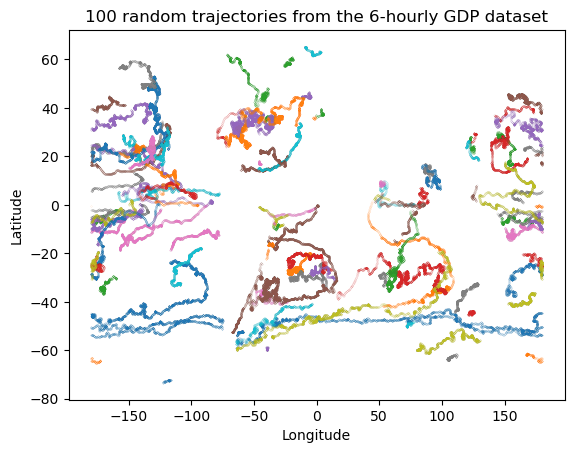

In [15]:
for drifter_id in drifter_ids:
    this_drifter = ds.ids == drifter_id
    plt.plot(ds.lon[this_drifter], ds.lat[this_drifter], linestyle='', marker='.', ms=0.1)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('100 random trajectories from the 6-hourly GDP dataset')

You may find that the method above is relatively slow to plot for a large number of trajectories. Alternatively, we can construct an index variable that indexes the beginning of each trajectory in the ragged arrays (with index `0` for the first trajectory). We first need to import the `numpy` package to conduct some mathematical operations to calculate that index variable.

In [16]:
import numpy as np

In [17]:
traj_idx = np.insert(np.cumsum(ds.rowsize.values),0,0)

Text(0.5, 1.0, '100 random trajectories from the 6-hourly GDP dataset')

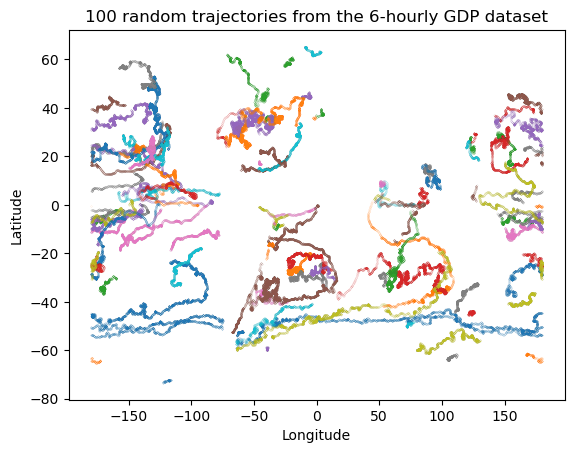

In [18]:
for j in range(len(drifter_ids)):
    plt.plot(ds.lon[slice(traj_idx[j],traj_idx[j+1])], ds.lat[slice(traj_idx[j],traj_idx[j+1])], linestyle='', marker='.', ms=0.1)    
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('100 random trajectories from the 6-hourly GDP dataset')

### Awkward Array

In [19]:
ds = ra.to_awkward()

With an awkward array, there is no need to define an index variable as for an xarray Dataset:

Text(0.5, 1.0, '100 random trajectories from a GDP dataset')

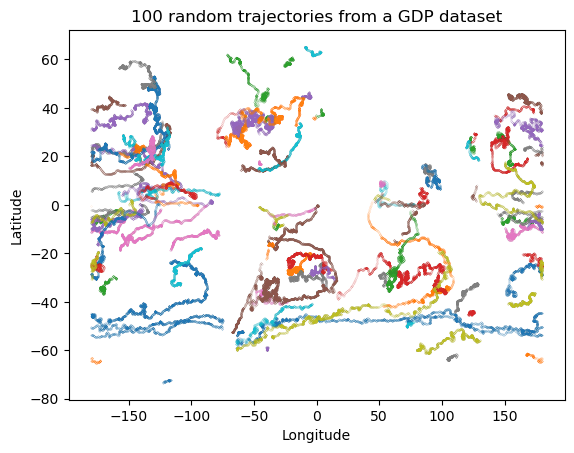

In [20]:
for n in range(len(drifter_ids)):
    plt.plot(ds.obs['lon'][n], ds.obs['lat'][n], linestyle='', marker='.', ms=0.1)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('100 random trajectories from a GDP dataset')